# CMS Open Data + Machine Learning
This notebook will take simulated and reconstructed proton-proton collision events from the 2011 CMS Open Data release and build a classifier for differentiating boosted, merged W boson jets from QCD jets. 
## Loading libraries
First we load the relevant libraries.

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import Dense
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
import numpy as np
import pandas as pd
import sys
import glob
import matplotlib.pyplot as plt
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Using Theano backend.


## Loading numpy arrays
Now we load two different numpy outputs. One corresponding to a sample of boosted, merged W->qq jets reconstructed from ttbar+jets simulation and one corresponding to QCD jets.

In [4]:
!cp -r /uscms_data/d3/jduarte1/DSHEP2017/CMSSW_5_3_32/src/2011-jet-inclusivecrosssection-ntupleproduction-optimized/AnalysisFW/python/output_* .

In [5]:
# get input numpy arrays
input_TT = glob.glob('output_TT/*.npy')
input_QCD = glob.glob('output_QCD170/*.npy')

list_params_TT = []
for in_file in input_TT:
    list_params_TT.append(np.load(in_file))
params_TT = np.concatenate(list_params_TT)
    
list_params_QCD = []
for in_file in input_QCD:
    list_params_QCD.append(np.load(in_file))
params_QCD = np.concatenate(list_params_QCD)

## Convert to Pandas DataFrame
Now we can convert the numpy arrays to data frames. First we can look at the features that are available. We can see that we have event-level information (`run`, `lumi`, `event`, `njet_ak7`), jet-level information (`jet_pt_ak7`, `jet_eta_ak7`, `jet_phi_ak7`, `jet_E_ak7`, `jet_msd_ak7`, `jet_area_ak7`, `jet_jes_ak7`, `jet_tau21_ak7`, `jet_isW_ak7`), and finally PF-candidate-level information (`ak7pfcand_pt`, `ak7pfcand_eta`, `ak7pfcand_phi`, `ak7pfcand_id`, `ak7pfcand_charge`, `ak7pfcand_ijet`). 

To start with, we'll just take the most relevant jet-level information as inputs (`jet_pt_ak7`, `jet_tau21_ak7`, `jet_msd_ak7`, `jet_ncand_ak7`) to try to predict whether the jet is a real boosted, merged W boson, which is given by the boolean `jet_isW_ak7` (The generator-level matching criteria is that a generated W boson which decays to qq is within the jet cone of 0.7 and the deltaR between the daughters is less than 0.7).

In [32]:
# convert to pandas dataframe
print params_TT.dtype.names
df_TT = pd.DataFrame(params_TT,columns=['jet_pt_ak7','jet_tau21_ak7','jet_msd_ak7','jet_ncand_ak7','jet_isW_ak7'])
df_QCD = pd.DataFrame(params_QCD,columns=['jet_pt_ak7','jet_tau21_ak7','jet_msd_ak7','jet_ncand_ak7','jet_isW_ak7'])

df_TT = df_TT.drop_duplicates()
df_TT =  df_TT[(df_TT.jet_pt_ak7 > 200) & (df_TT.jet_isW_ak7==1)]
    
df_QCD = df_QCD.drop_duplicates()
df_QCD =  df_QCD[(df_QCD.jet_pt_ak7 > 200) & (df_QCD.jet_isW_ak7==0)]

# take every 30th row just to make the training faster
df_QCD = df_QCD.iloc[::30, :]

df = pd.concat([df_TT,df_QCD])

print df_TT.iloc[:3]
print df_QCD.iloc[:3]

('run', 'lumi', 'event', 'njet_ak7', 'jet_pt_ak7', 'jet_eta_ak7', 'jet_phi_ak7', 'jet_E_ak7', 'jet_msd_ak7', 'jet_area_ak7', 'jet_jes_ak7', 'jet_tau21_ak7', 'jet_isW_ak7', 'jet_ncand_ak7', 'ak7pfcand_pt', 'ak7pfcand_eta', 'ak7pfcand_phi', 'ak7pfcand_id', 'ak7pfcand_charge', 'ak7pfcand_ijet')
       jet_pt_ak7  jet_tau21_ak7  jet_msd_ak7  jet_ncand_ak7  jet_isW_ak7
5686   383.039639       0.534750   105.270651            147            1
9408   266.859226       0.260437    84.983585             49            1
21721  299.589020       0.224062    92.450708             40            1
      jet_pt_ak7  jet_tau21_ak7  jet_msd_ak7  jet_ncand_ak7  jet_isW_ak7
219   242.214637       0.613920    46.280751             58            0
3168  208.003269       0.709101    36.922355             54            0
7625  201.391454       0.699930    16.072006             37            0


## Plotting inputs
Let's make some plots of the inputs for both W and QCD jets, specifically the soft-drop mass `jet_msd_ak7` and the n-subjettiness substructure variable`jet_tau21_ak7`.

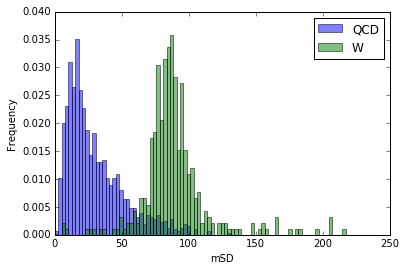

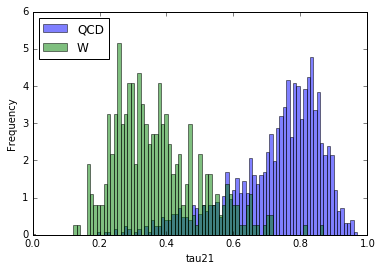

In [10]:
%matplotlib inline
plt.figure()
plt.xlabel('mSD')
bins = np.linspace(0, 250, 100)
df_QCD['jet_msd_ak7'].plot.hist(bins, alpha=0.5, label='QCD',normed=True)
df_TT['jet_msd_ak7'].plot.hist(bins, alpha=0.5, label='W',normed=True)
plt.legend(loc='upper right')
plt.figure()
plt.xlabel('tau21')
bins = np.linspace(0, 1, 100)
df_QCD['jet_tau21_ak7'].plot.hist(bins, alpha=0.5, label='QCD',normed=True)
df_TT['jet_tau21_ak7'].plot.hist(bins, alpha=0.5, label='W',normed=True)
plt.legend(loc='upper left')

## Defining our model (neural net topology)
We'll start with the classic densely-connected NN layer. Our model will have a single fully connected hidden layer with the same number of neurons as input variables. The weights are initialized using a small Gaussian random number. The Rectifier activation function is used. The output layer contains a single neuron in order to make predictions. It uses the sigmoid activation function in order to produce a probability output in the range of 0 to 1 that can easily and automatically be converted to class values (0 or 1).

Finally, we are using the logarithmic loss function (`binary_crossentropy`) during training, the preferred loss function for binary classification problems. The model also uses the efficient Adam optimization algorithm for gradient descent and accuracy metrics will be collected when the model is trained.

In [49]:
# baseline model
NDIM = 4
def create_baseline():
    # create model
    model = Sequential()
    # this works for keras 2.0.3
    #model.add(Dense(NDIM, input_dim=NDIM, kernel_initializer='normal', activation='relu'))
    #model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # this works for keras 1.2.2 (CMSSW_9_0_1)
    model.add(Dense(NDIM, init='normal', input_dim=NDIM, activation='relu'))
    model.add(Dense(1, init='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model = create_baseline()
model.summary()
# visalize model
#from keras.utils.visualize_util import plot
#plot(model)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_53 (Dense)                 (None, 4)             20          dense_input_27[0][0]             
____________________________________________________________________________________________________
dense_54 (Dense)                 (None, 1)             5           dense_53[0][0]                   
Total params: 25
Trainable params: 25
Non-trainable params: 0
____________________________________________________________________________________________________


## Cross validation
Now we can evaluate this model using stratified cross validation in the scikit-learn framework.

We pass the number of training epochs to the KerasClassifier, again using reasonable default values. Verbose output is also turned off given that the model will be created 3 times for the 3-fold cross validation being performed.

Running this code produces the following output showing the mean and standard deviation of the estimated accuracy of the model on unseen data.

In [50]:
dataset = df.values
X = dataset[:,0:NDIM].astype(float)
Y = dataset[:,NDIM]
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# evaluate baseline model
# this works for keras 2.0.3
#estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
# this works for keras 1.2.2 (CMSSW_9_0_1)
estimator = KerasClassifier(build_fn=create_baseline, nb_epoch=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
print "Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)

Results: 92.65% (0.48%)


## Visualize performance with ROC curves
Here, we visualize the performance of our model with a ROC curve for each cross validation sample.

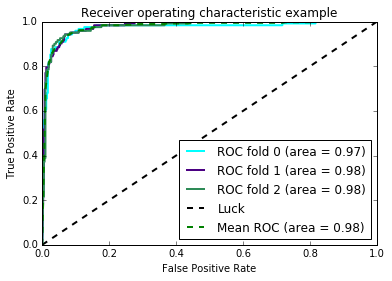

In [52]:
# Run classifier with cross-validation and plot ROC curves
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'black', 'green', 'brown'])
lw = 2

i = 0
for (train, test), color in zip(kfold.split(X, encoded_Y), colors):
    history = model.fit(X[train], encoded_Y[train], nb_epoch=100, batch_size=5, verbose=0)
    Y_score = model.predict(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(encoded_Y[test], Y_score)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')

mean_tpr /= kfold.get_n_splits(X, encoded_Y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()